# No time interpolation is used in this workbook

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.linalg import eigh
from scipy.signal import find_peaks
from scipy.integrate import simps

from collections import Counter
from itertools import product
from collections import namedtuple

from multiprocessing import Pool
from tqdm.notebook import tqdm

import cvxpy as cp

import os

# Loading and pre-processing pulses

Load pulses. Note that each pulse has its own time axis

In [2]:
folder_data = "experimental data 01-24-2022"

os.listdir(folder_data)

['export_SO_N6_test_short_x.txt',
 'export_SO_N6_test_long_x.txt',
 'export_SO_N9_test_long_x.txt',
 'export_SO_N4_test_short_x.txt',
 'export_SO_N9_test_short_x.txt',
 'export_SO_N3_test_long_x.txt',
 'export_SO_N5_test_long_x.txt',
 'export_SO_N4_test_long_x.txt',
 'export_SO_N2_test_long_x.txt',
 'export_SO_N7_test_long_x.txt',
 'export_SO_N1_test_long_x.txt',
 'export_F07_SO_test_x.txt',
 'export_SO_N7_test_short_x.txt',
 'export_SO_N8_test_long_x.txt',
 'export_SO_N5_test_short_x.txt',
 'export_SO_N1_test_short_x.txt',
 'export_F05_SO_test_x.txt',
 'export_SO_N10_test_short_x.txt',
 'export_SO_N8_test_short_x.txt',
 'export_SO_N10_test_long_x.txt',
 'export_SO_N2_test_short_x.txt',
 'export_SO_N3_test_short_x.txt',
 'export_F06_SO_test_x.txt',
 'export_F08_SO_test_x.txt']

## Loading "pure" pulses

In [3]:
pulses = {}

# declare type
Pulse = namedtuple('Pulse', ['time', 'field', 'peaks_indx', 'half_period'])

# save index where the field reseaches its maximum
maxima_position = {}

for freq in range(5, 9):
    data = np.loadtxt(
        folder_data + '/export_F0{}_SO_test_x.txt'.format(freq)
    )
    time, field = data.T

    dtime = np.unique(np.diff(time))
    assert np.allclose(dtime[0], dtime), "This workbook cannot be used since the time data is not equally spaced"
    
    label = '0.{} THz'.format(freq)
    
    # Relabel time axis such that peak field is at zero time 
    abs_field = np.abs(field)
    indx = abs_field.argmax()
    maxima_position[label] = indx
    #time -= time[indx] 
    
    
    # Extract information for the combinatorial method     
    peaks_indx = find_peaks(abs_field)[0]
    
    half_period = Counter(np.diff(time[peaks_indx])).most_common(1)[0][0]
    
    # Saving the data 
    pulses[label] = Pulse(
        time, 
        field, 
        peaks_indx, 
        half_period,
    )

#  Checking whether the time axis coincide
assert all(np.allclose(time, data.time) for data in pulses.values()), \
    "This workbook cannot be used since the time data is not syncronized"

# saving time step
dtime = dtime[0]

# saving the largest frequency
largest_freq = label

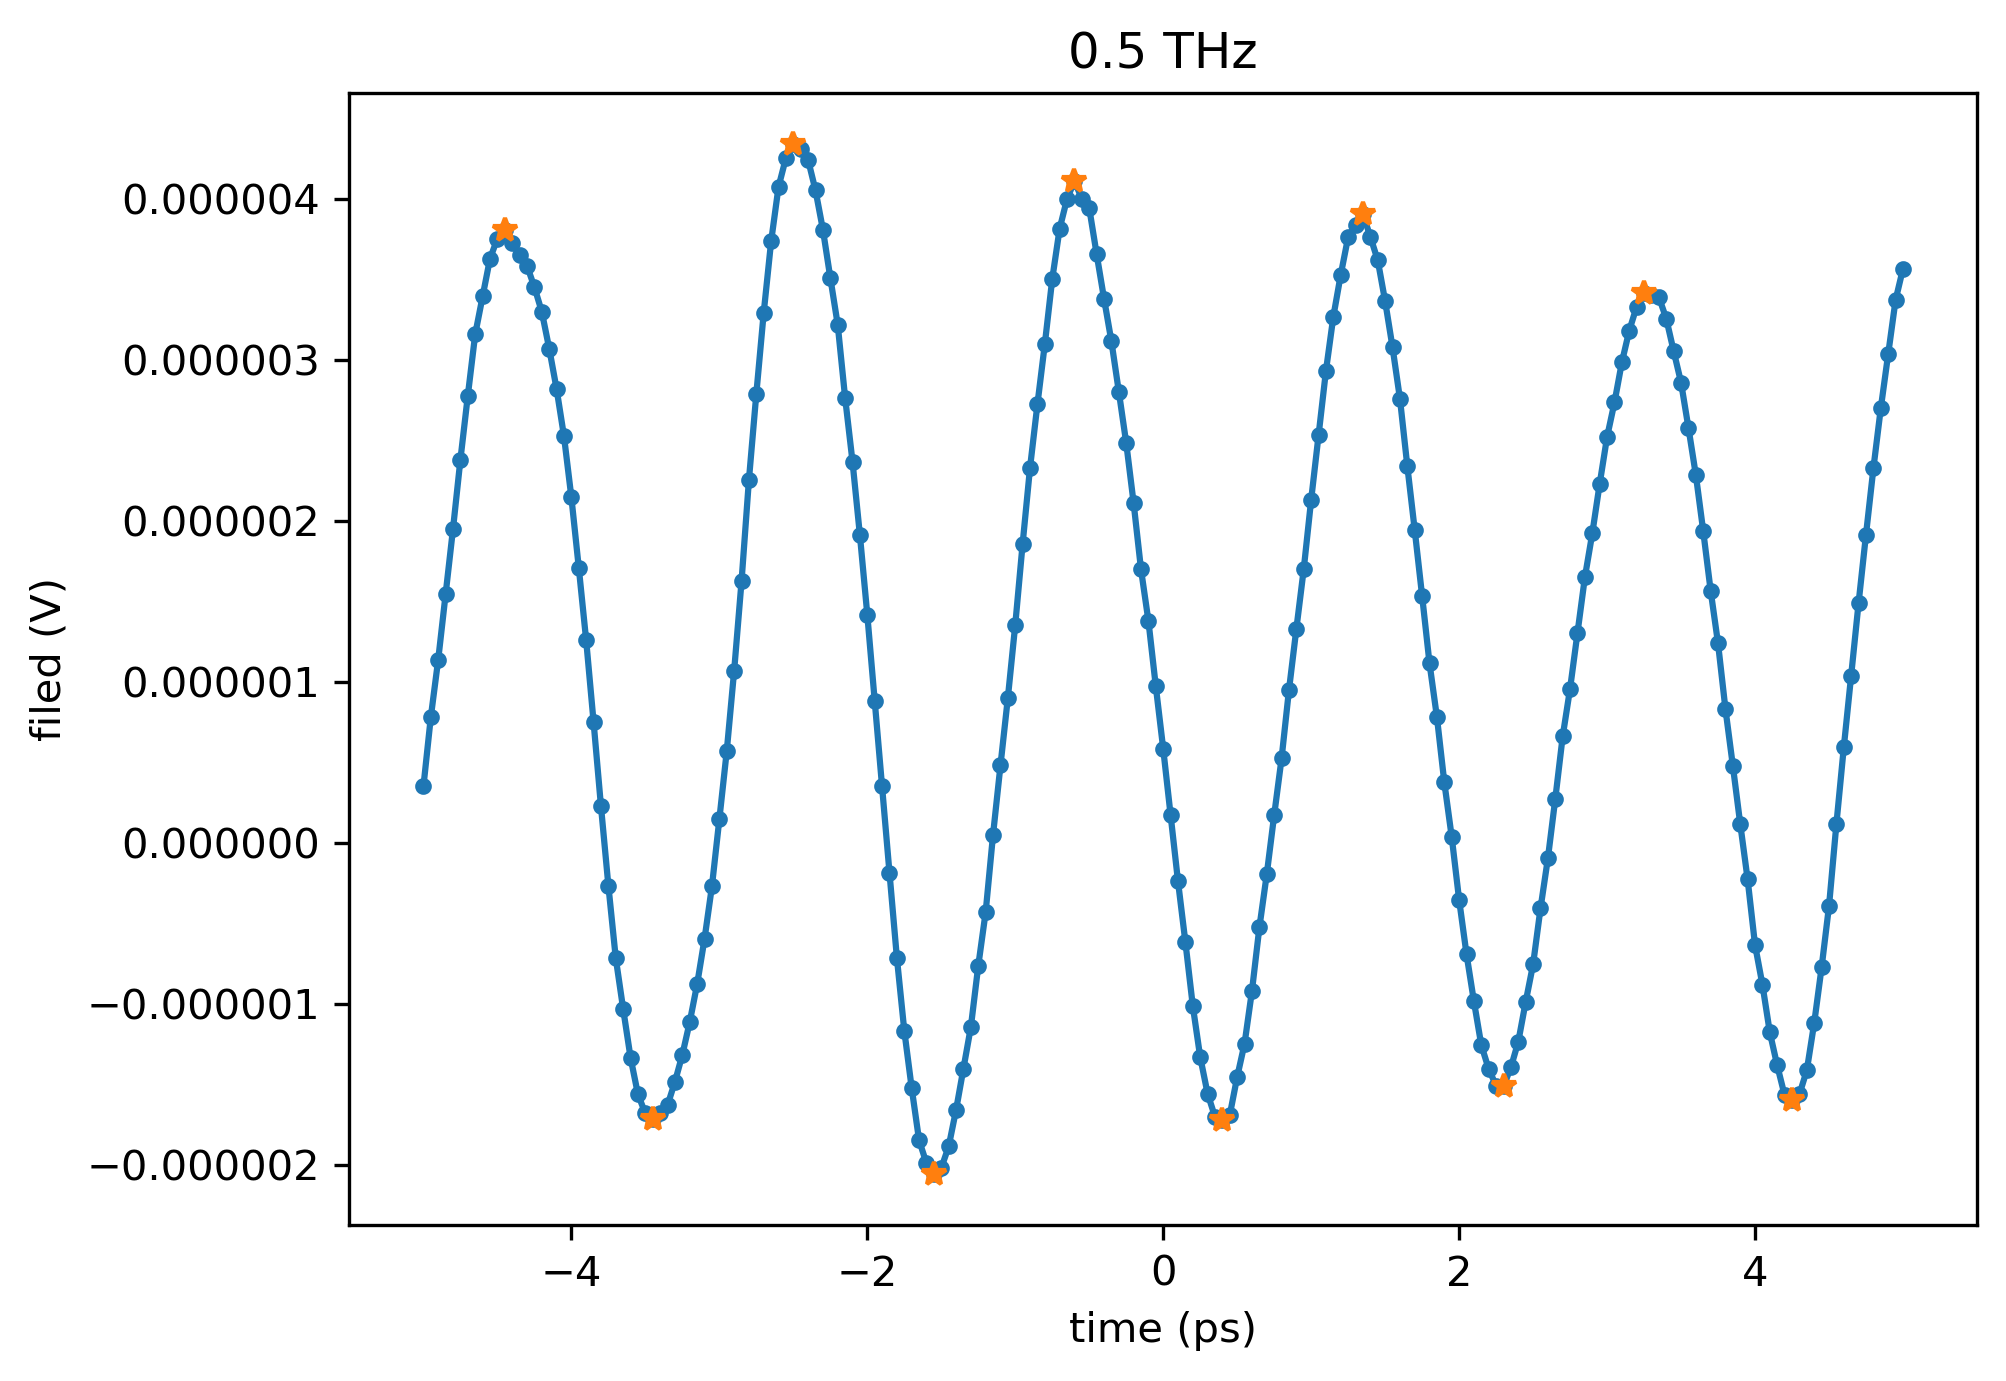

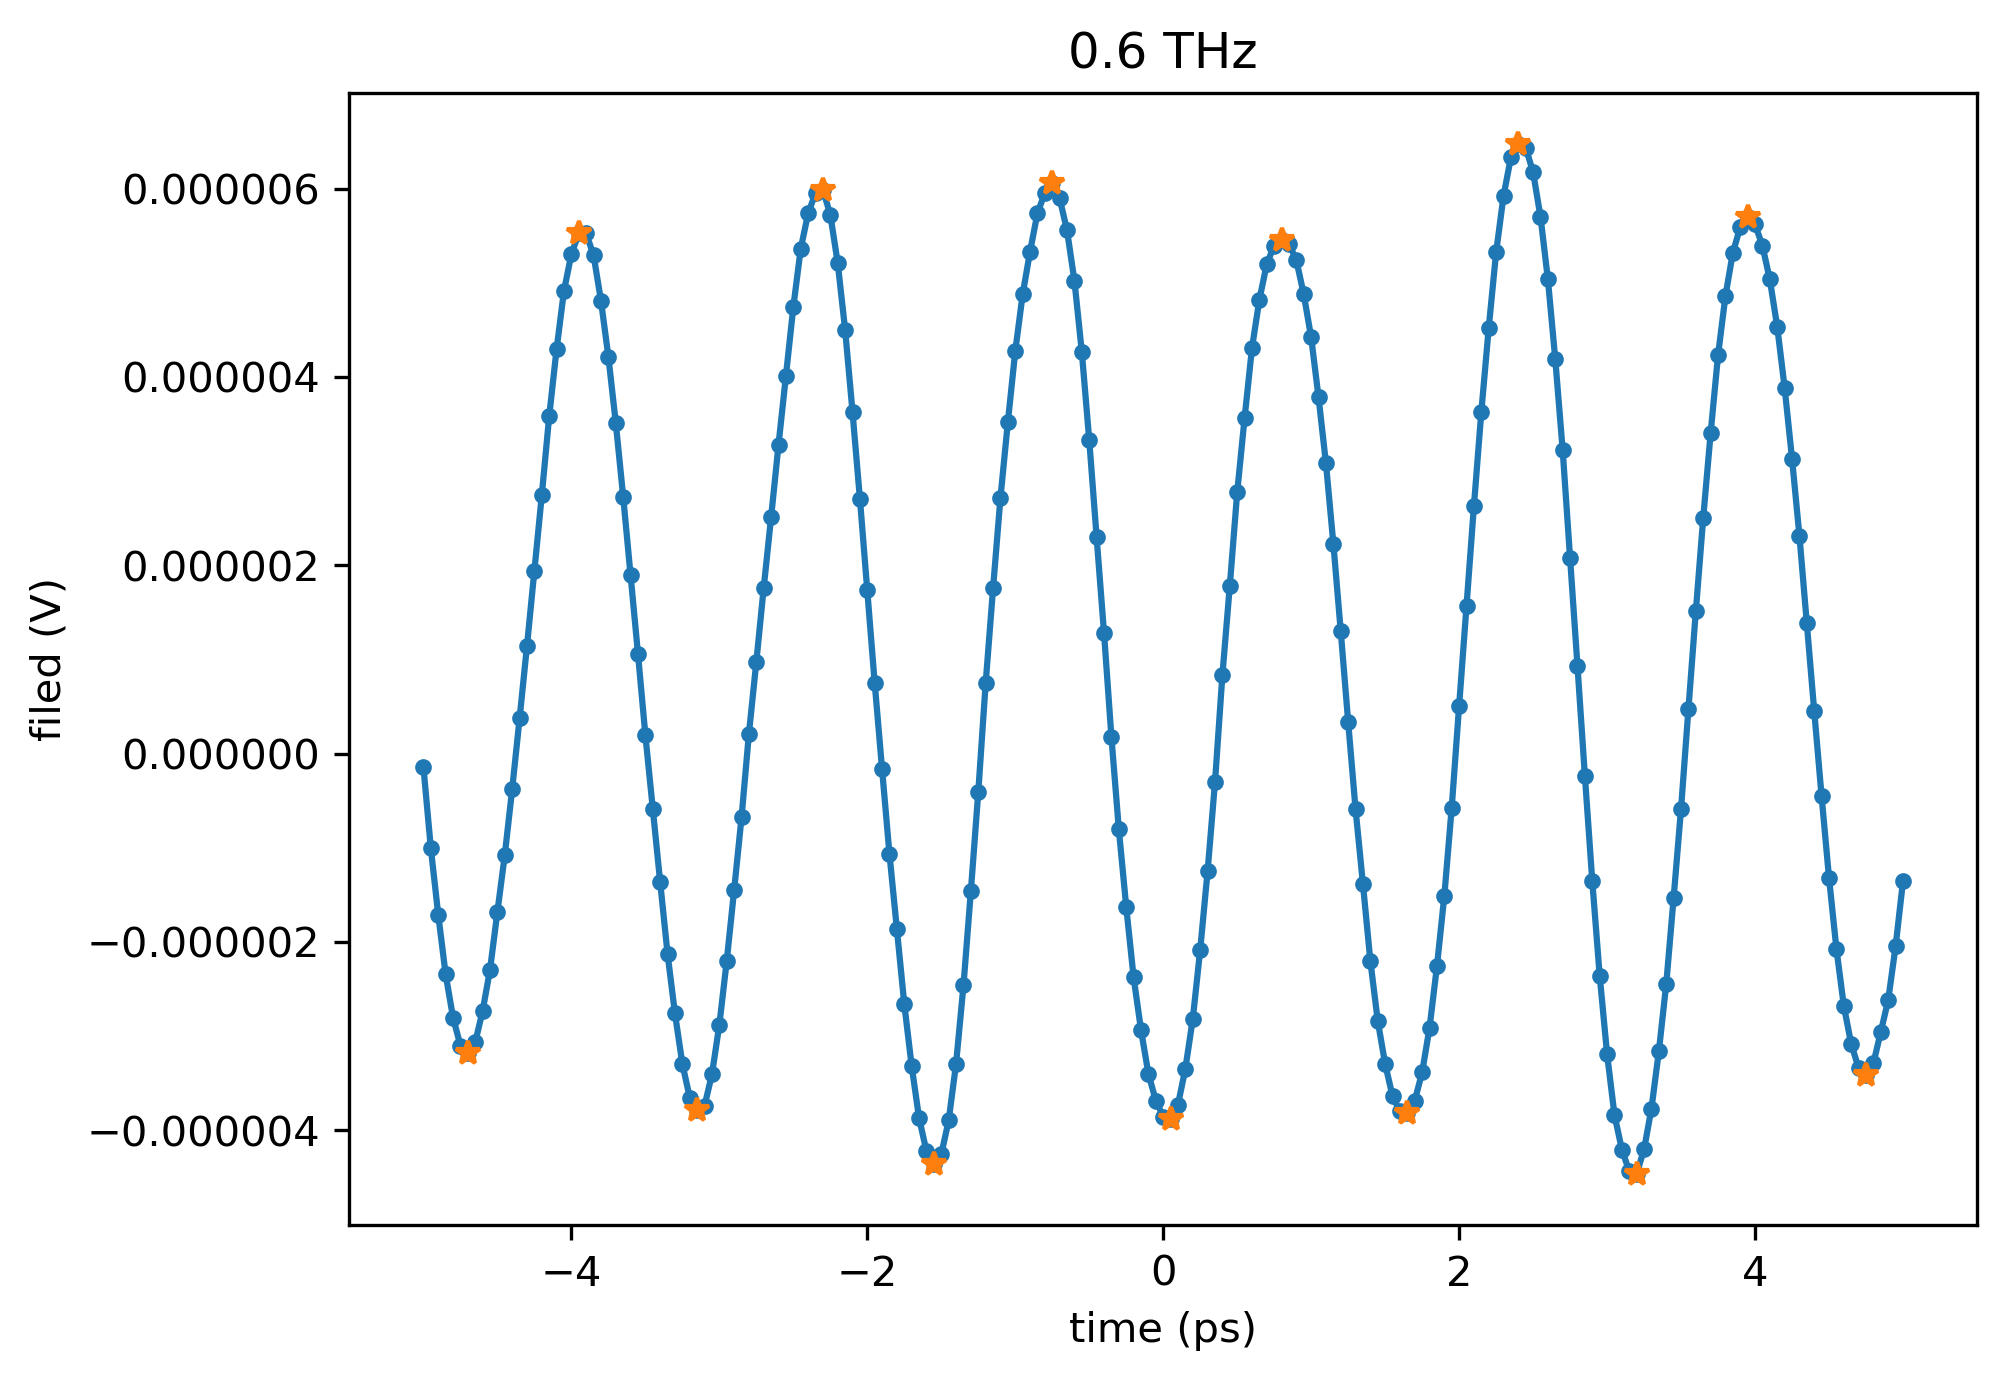

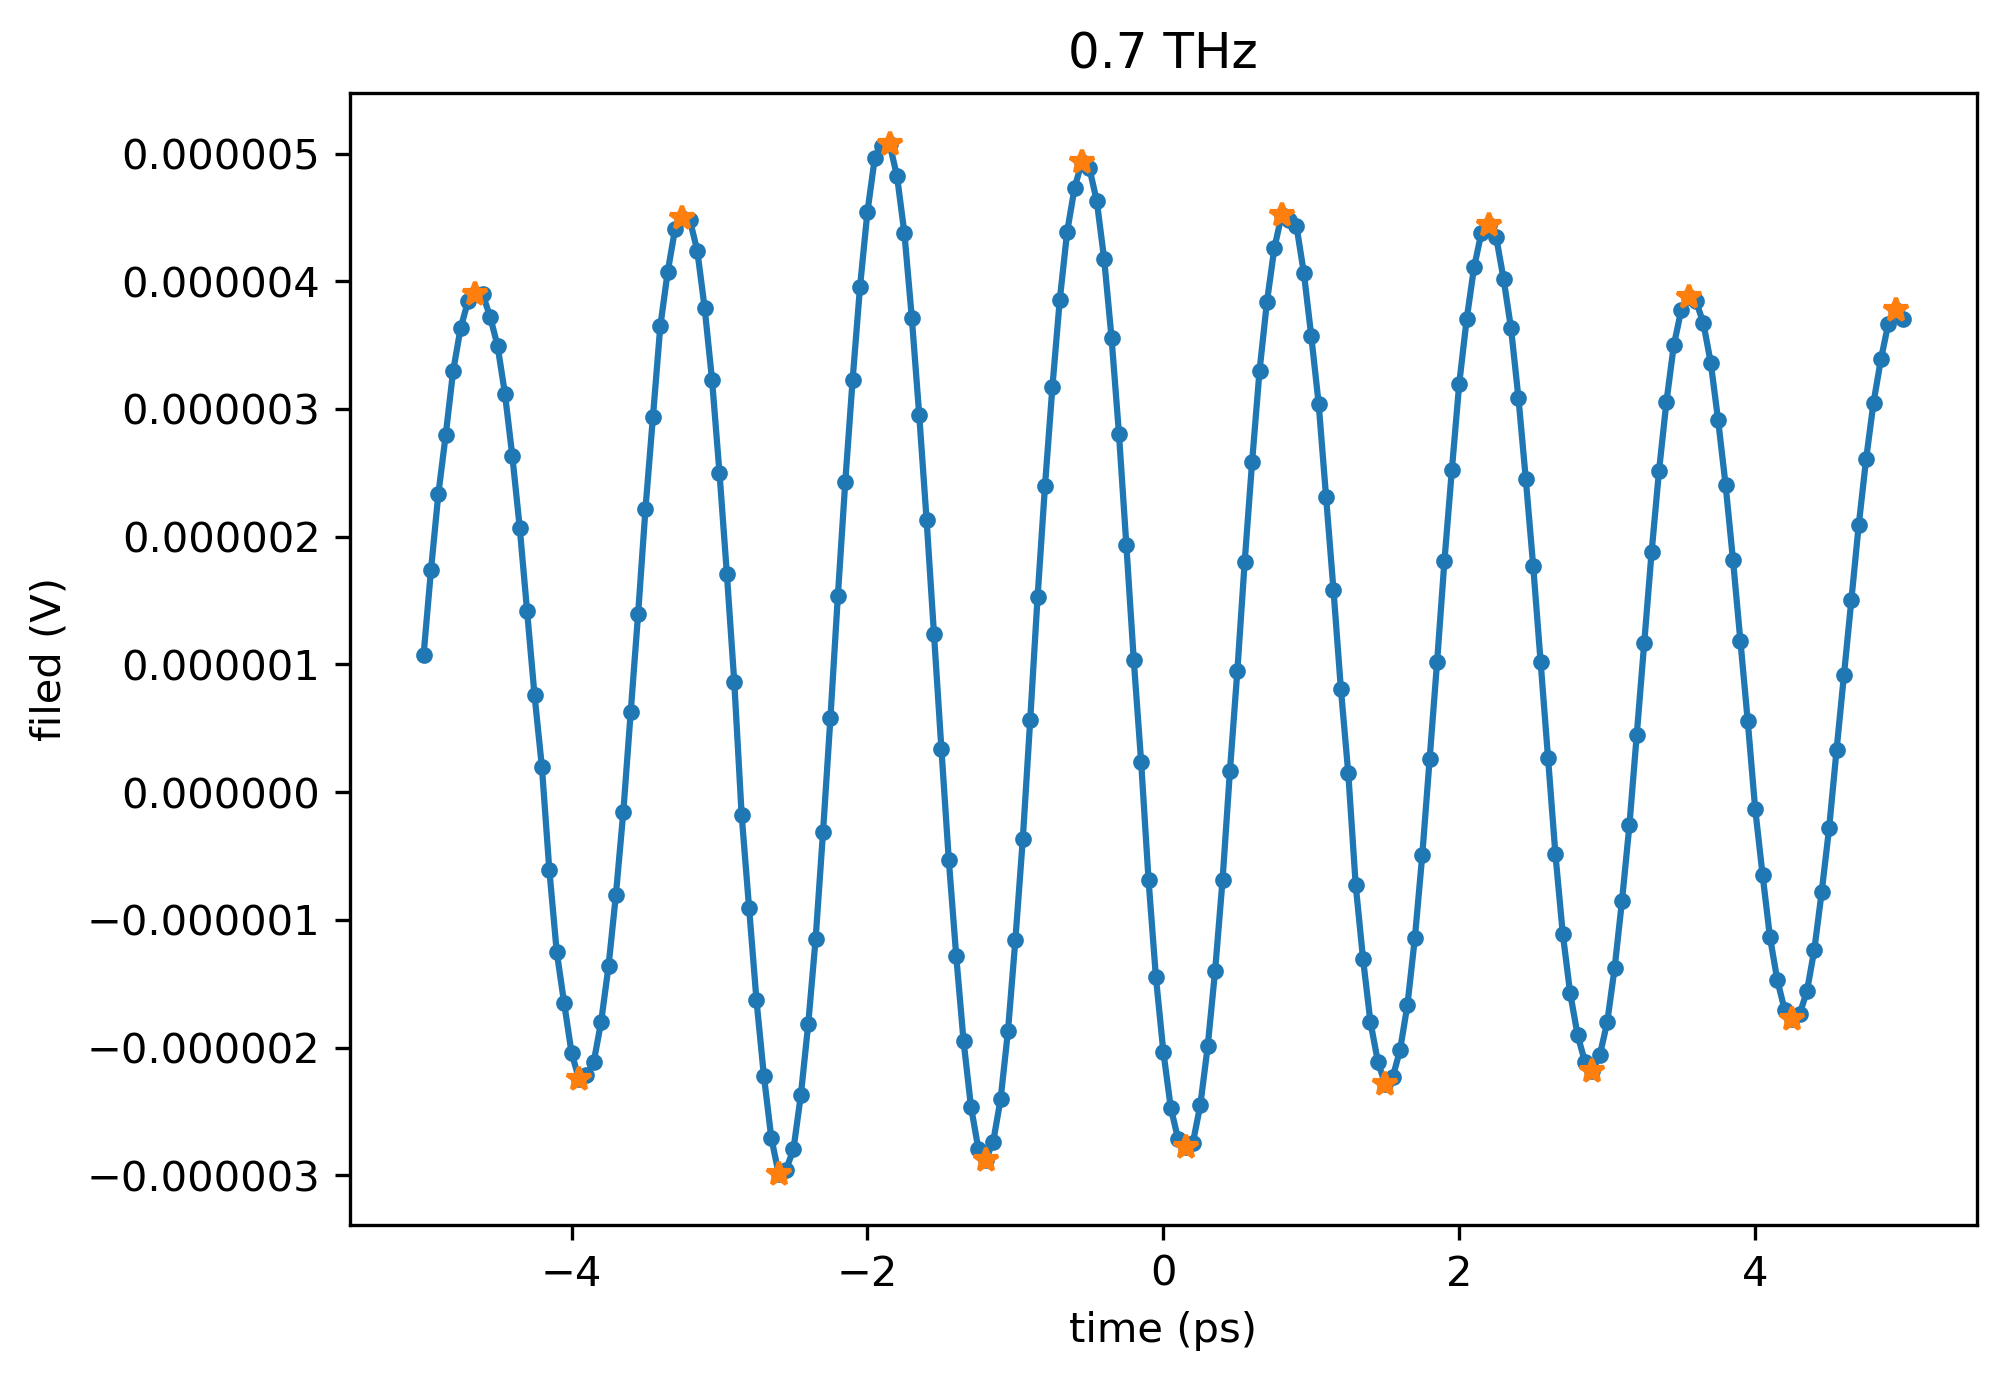

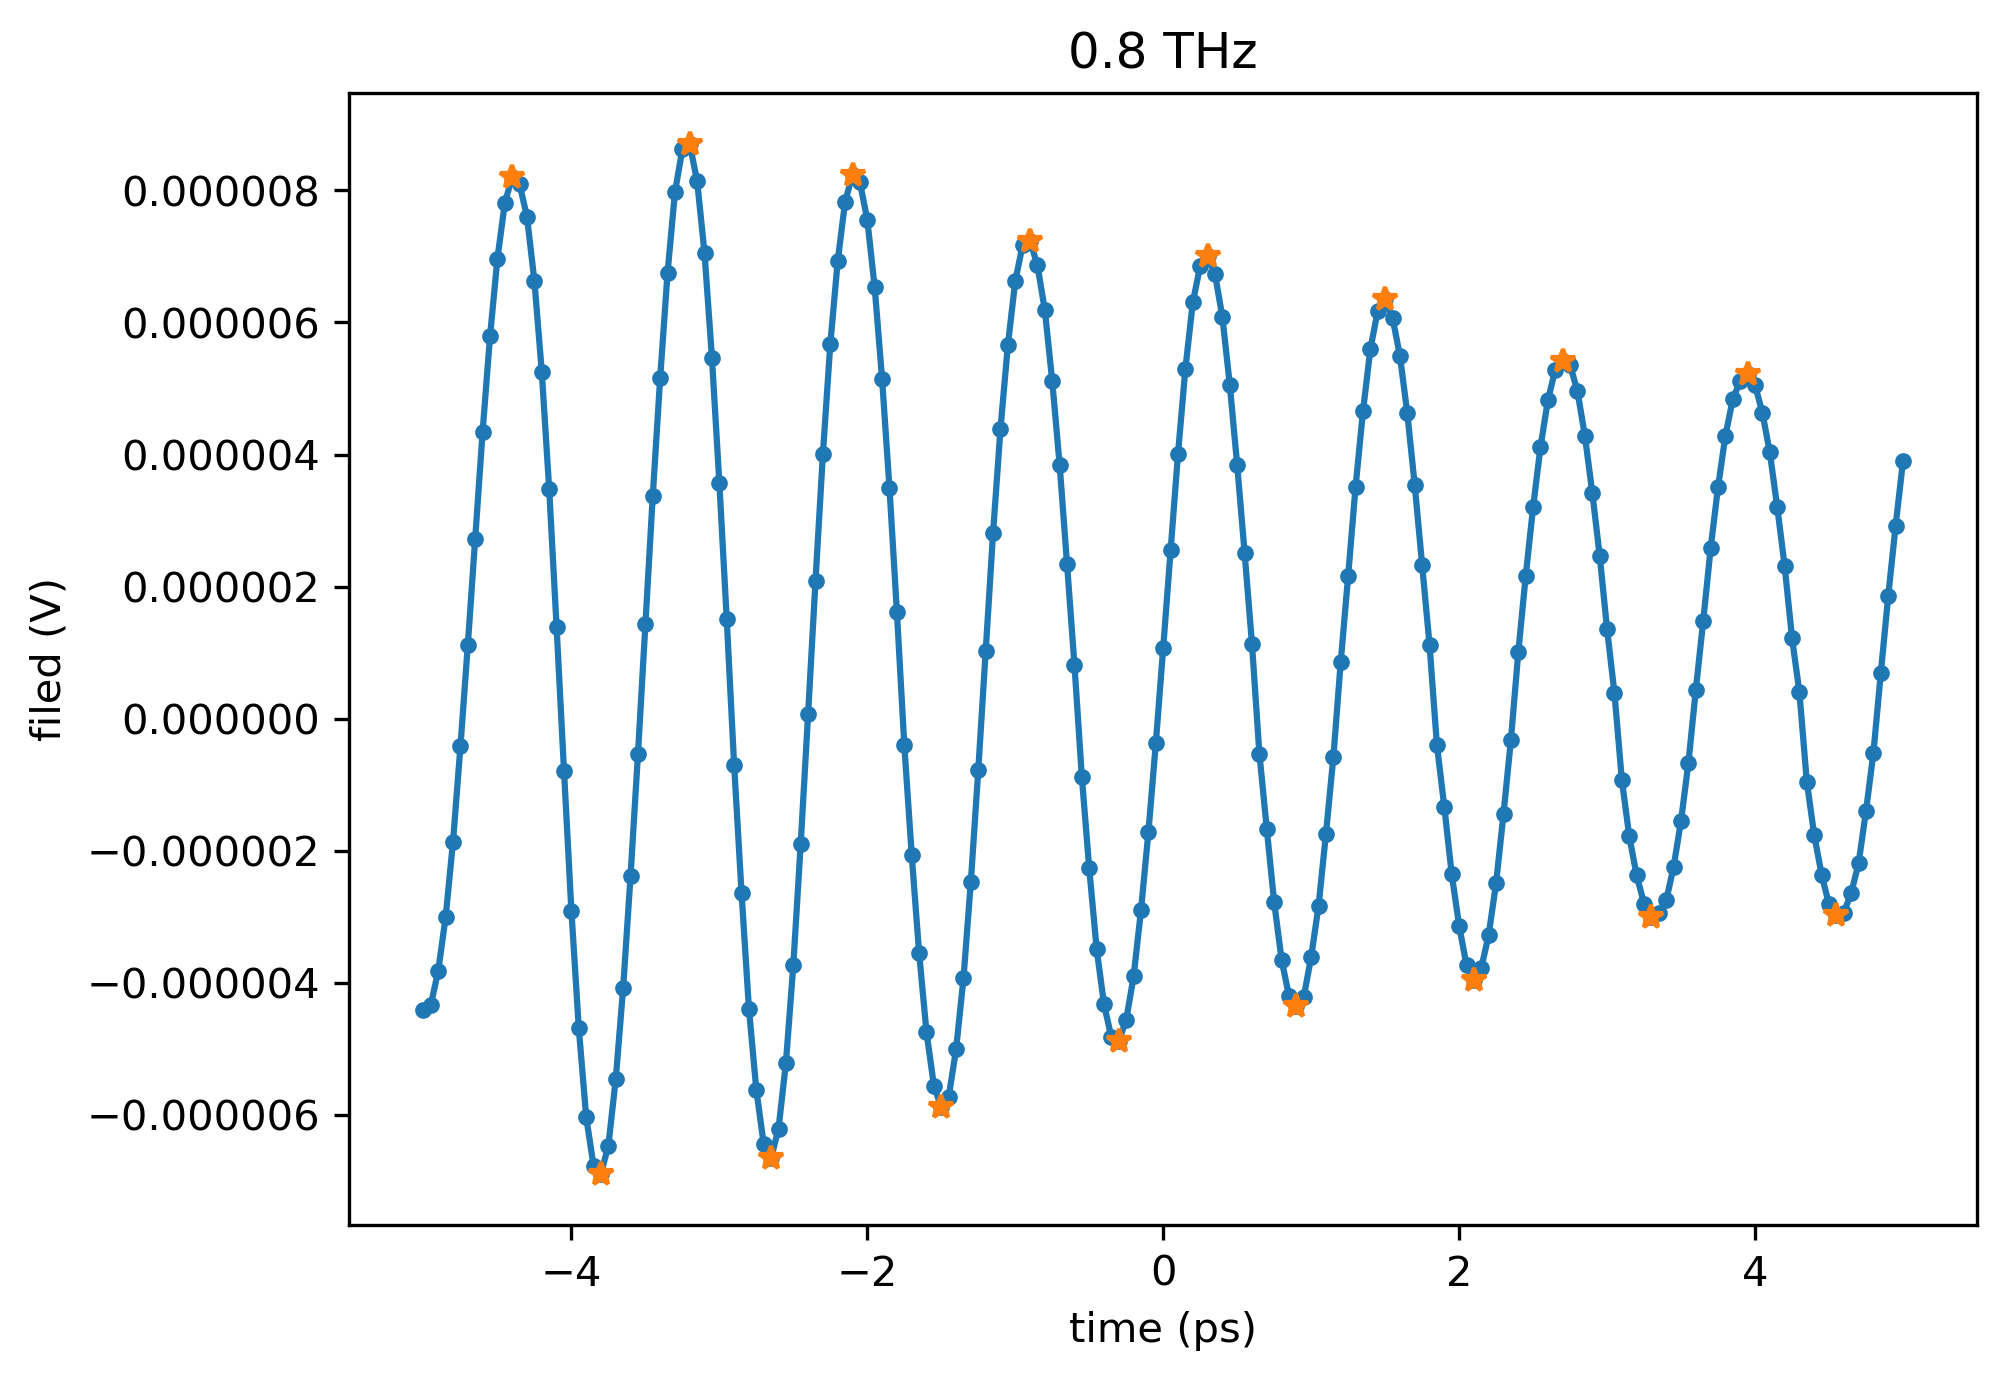

In [4]:
# Plot pulses
for freq, data in pulses.items():
    
    plt.figure(figsize=(7, 5), dpi=300)
    plt.title(freq)
    
    plt.plot(data.time, data.field, '.-')
    plt.plot(data.time[data.peaks_indx], data.field[data.peaks_indx], '*')
    plt.xlabel('time (ps)')
    plt.ylabel('filed (V)')
    plt.show()  
    

## Load experimental superoscilations

In [5]:
def load_experimental_so(file_template):
    loaded_so = []

    for n in range(1, 11):
        data = np.loadtxt(folder_data + file_template.format(n))
        time, field = data.T

        # check that time is time
        assert np.all(np.diff(time) > 0), "`time` is probably not time"

        loaded_so.append(
            Pulse(
                time, 
                field, 
                None,
                None
            )
        )
        
    return loaded_so

long_experimental_so = load_experimental_so('/export_SO_N{}_test_long_x.txt')
short_experimental_so = load_experimental_so('/export_SO_N{}_test_short_x.txt')

assert len(long_experimental_so) == len(short_experimental_so)

### Plotting short and long measurement at the same time  

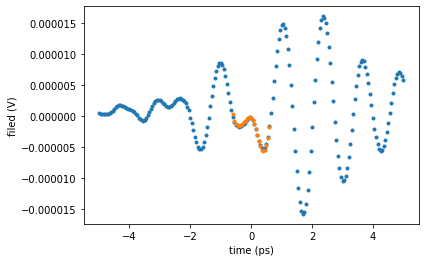

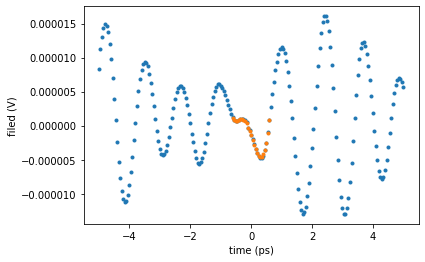

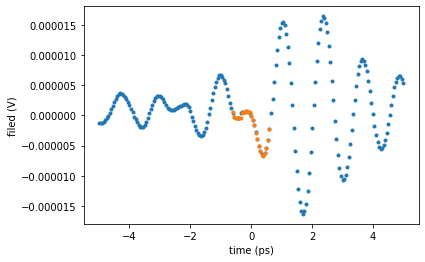

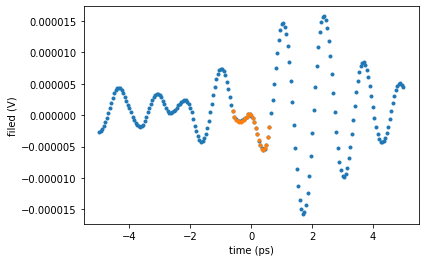

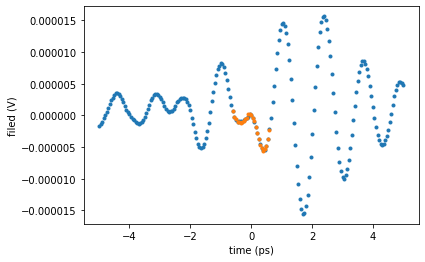

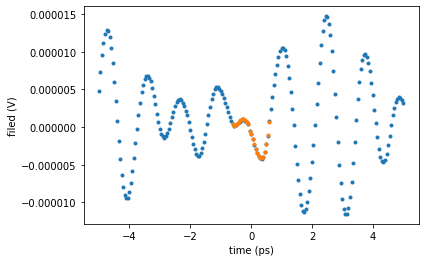

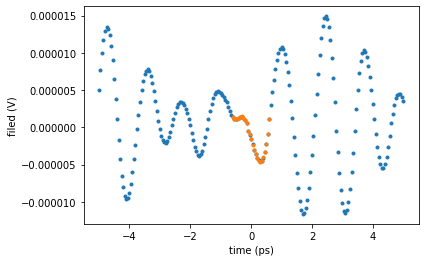

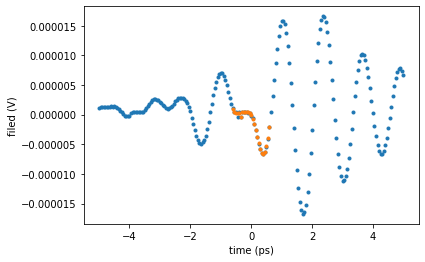

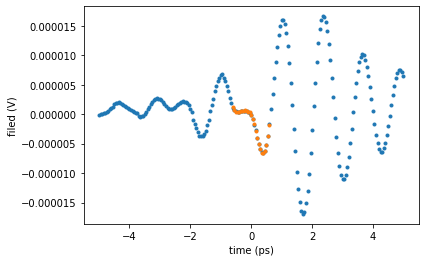

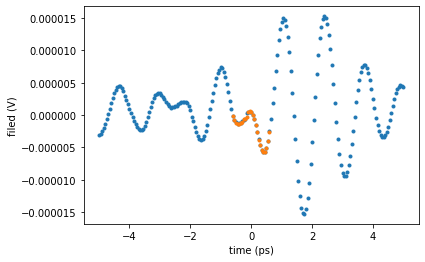

In [6]:
for long, short in zip(long_experimental_so, short_experimental_so):
    plt.plot(long.time, long.field, '.')
    plt.plot(short.time, short.field, '.')
    plt.xlabel('time (ps)')
    plt.ylabel('filed (V)')
    plt.show()

### Manually extract observational time window 

0.6000000000000001


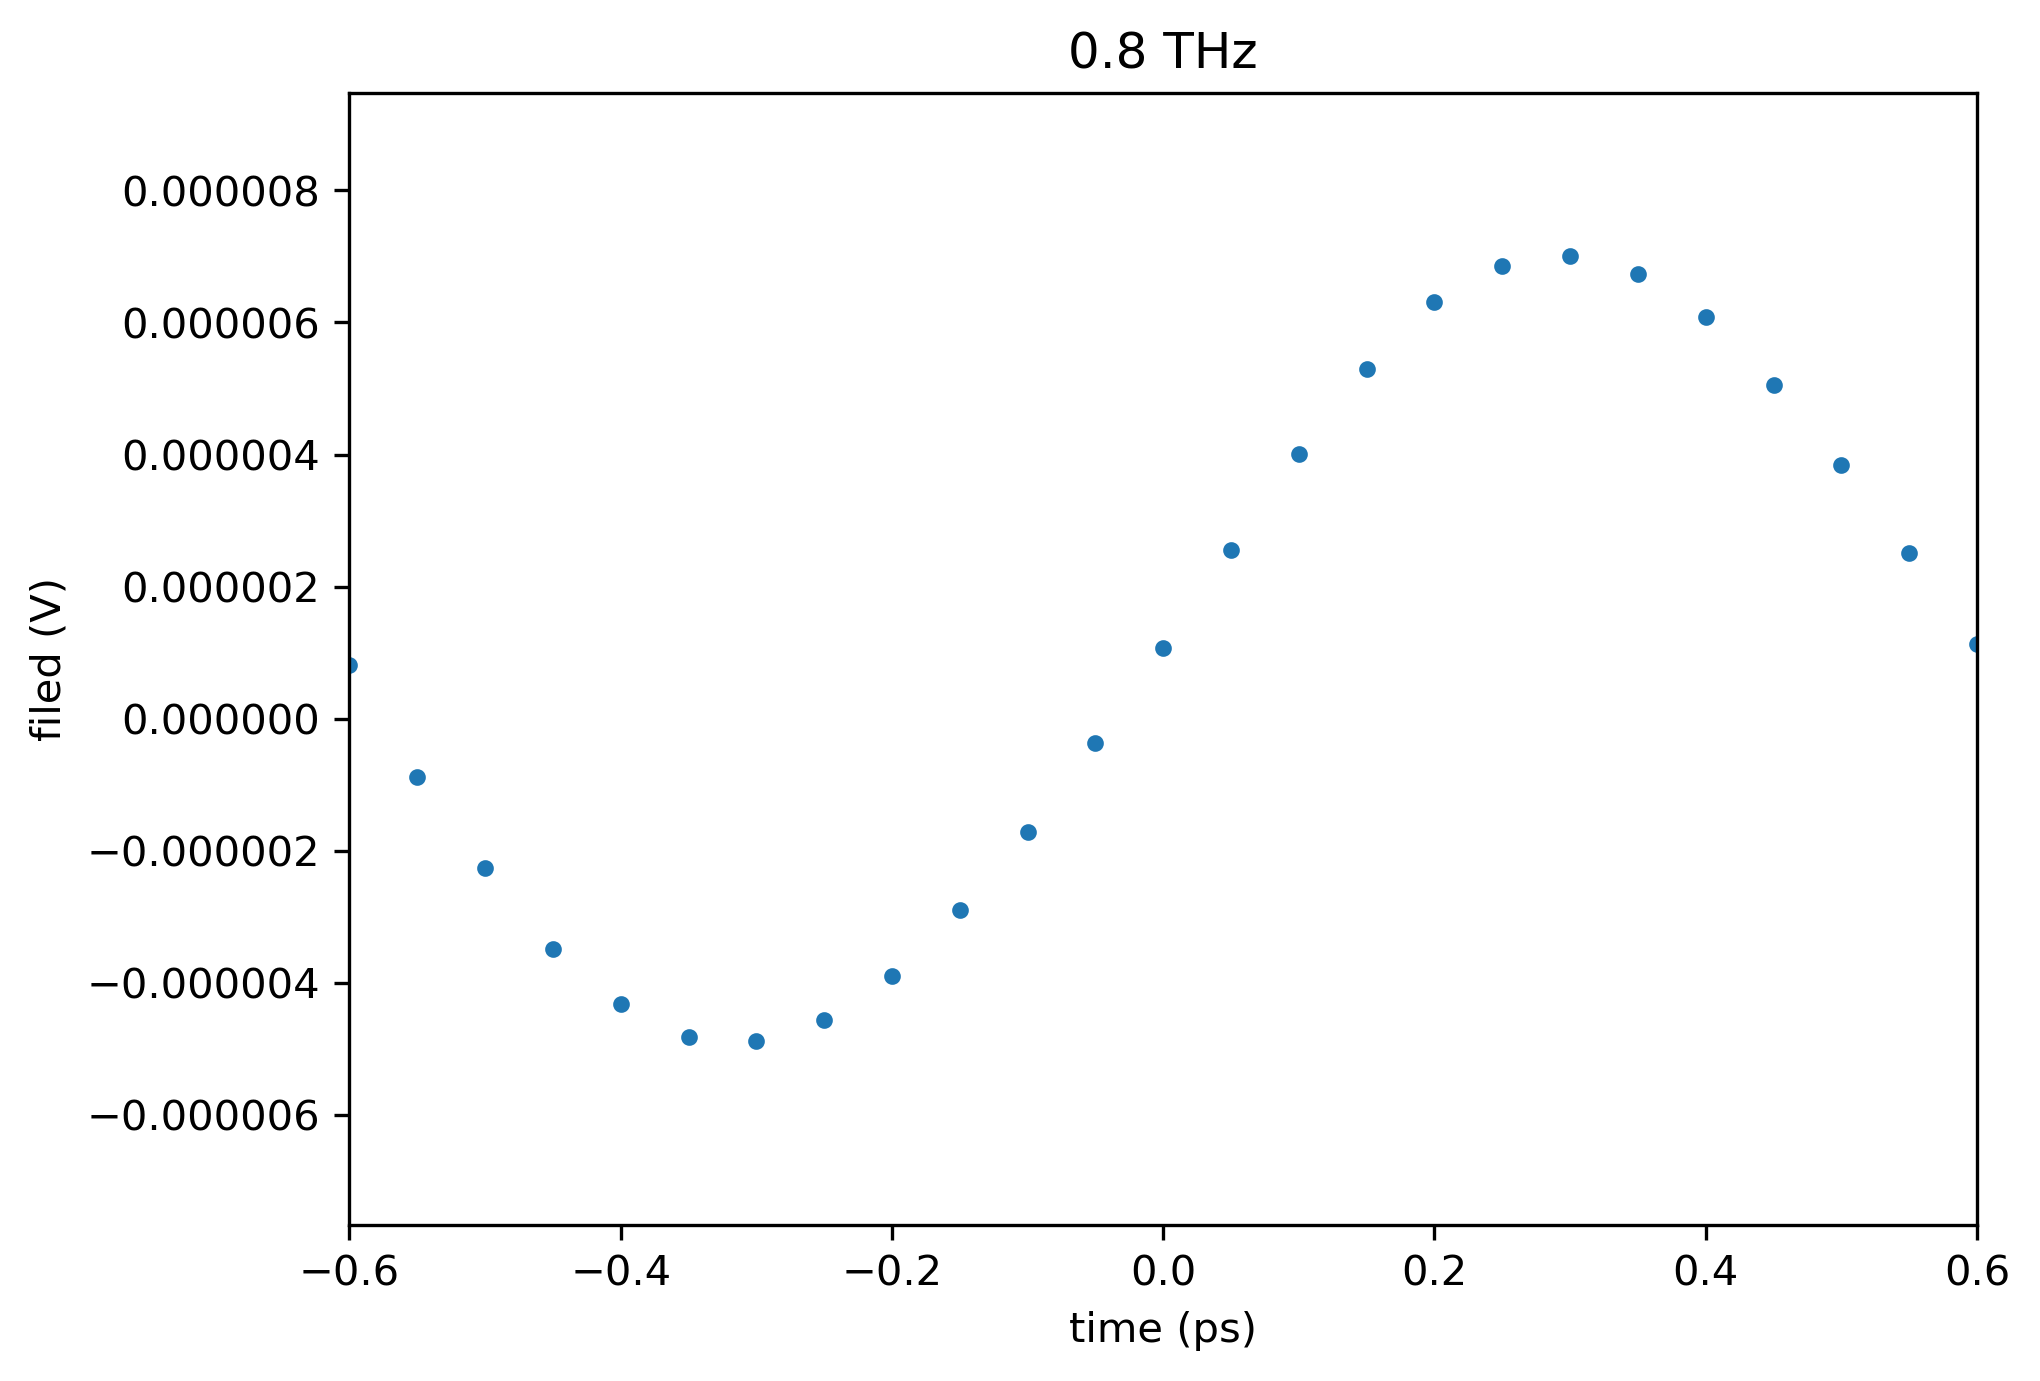

In [7]:
plt.figure(figsize=(7, 5), dpi=300)
    
time = pulses[largest_freq].time
field = pulses[largest_freq].field
half_period = pulses[largest_freq].half_period

print(half_period)

plt.plot(time, field, '.')

observational_window = -half_period, half_period

plt.xlim(observational_window)
plt.xlabel('time (ps)')
plt.ylabel('filed (V)')
plt.title(largest_freq)    
plt.show()

### Plot all pulses within the observational window

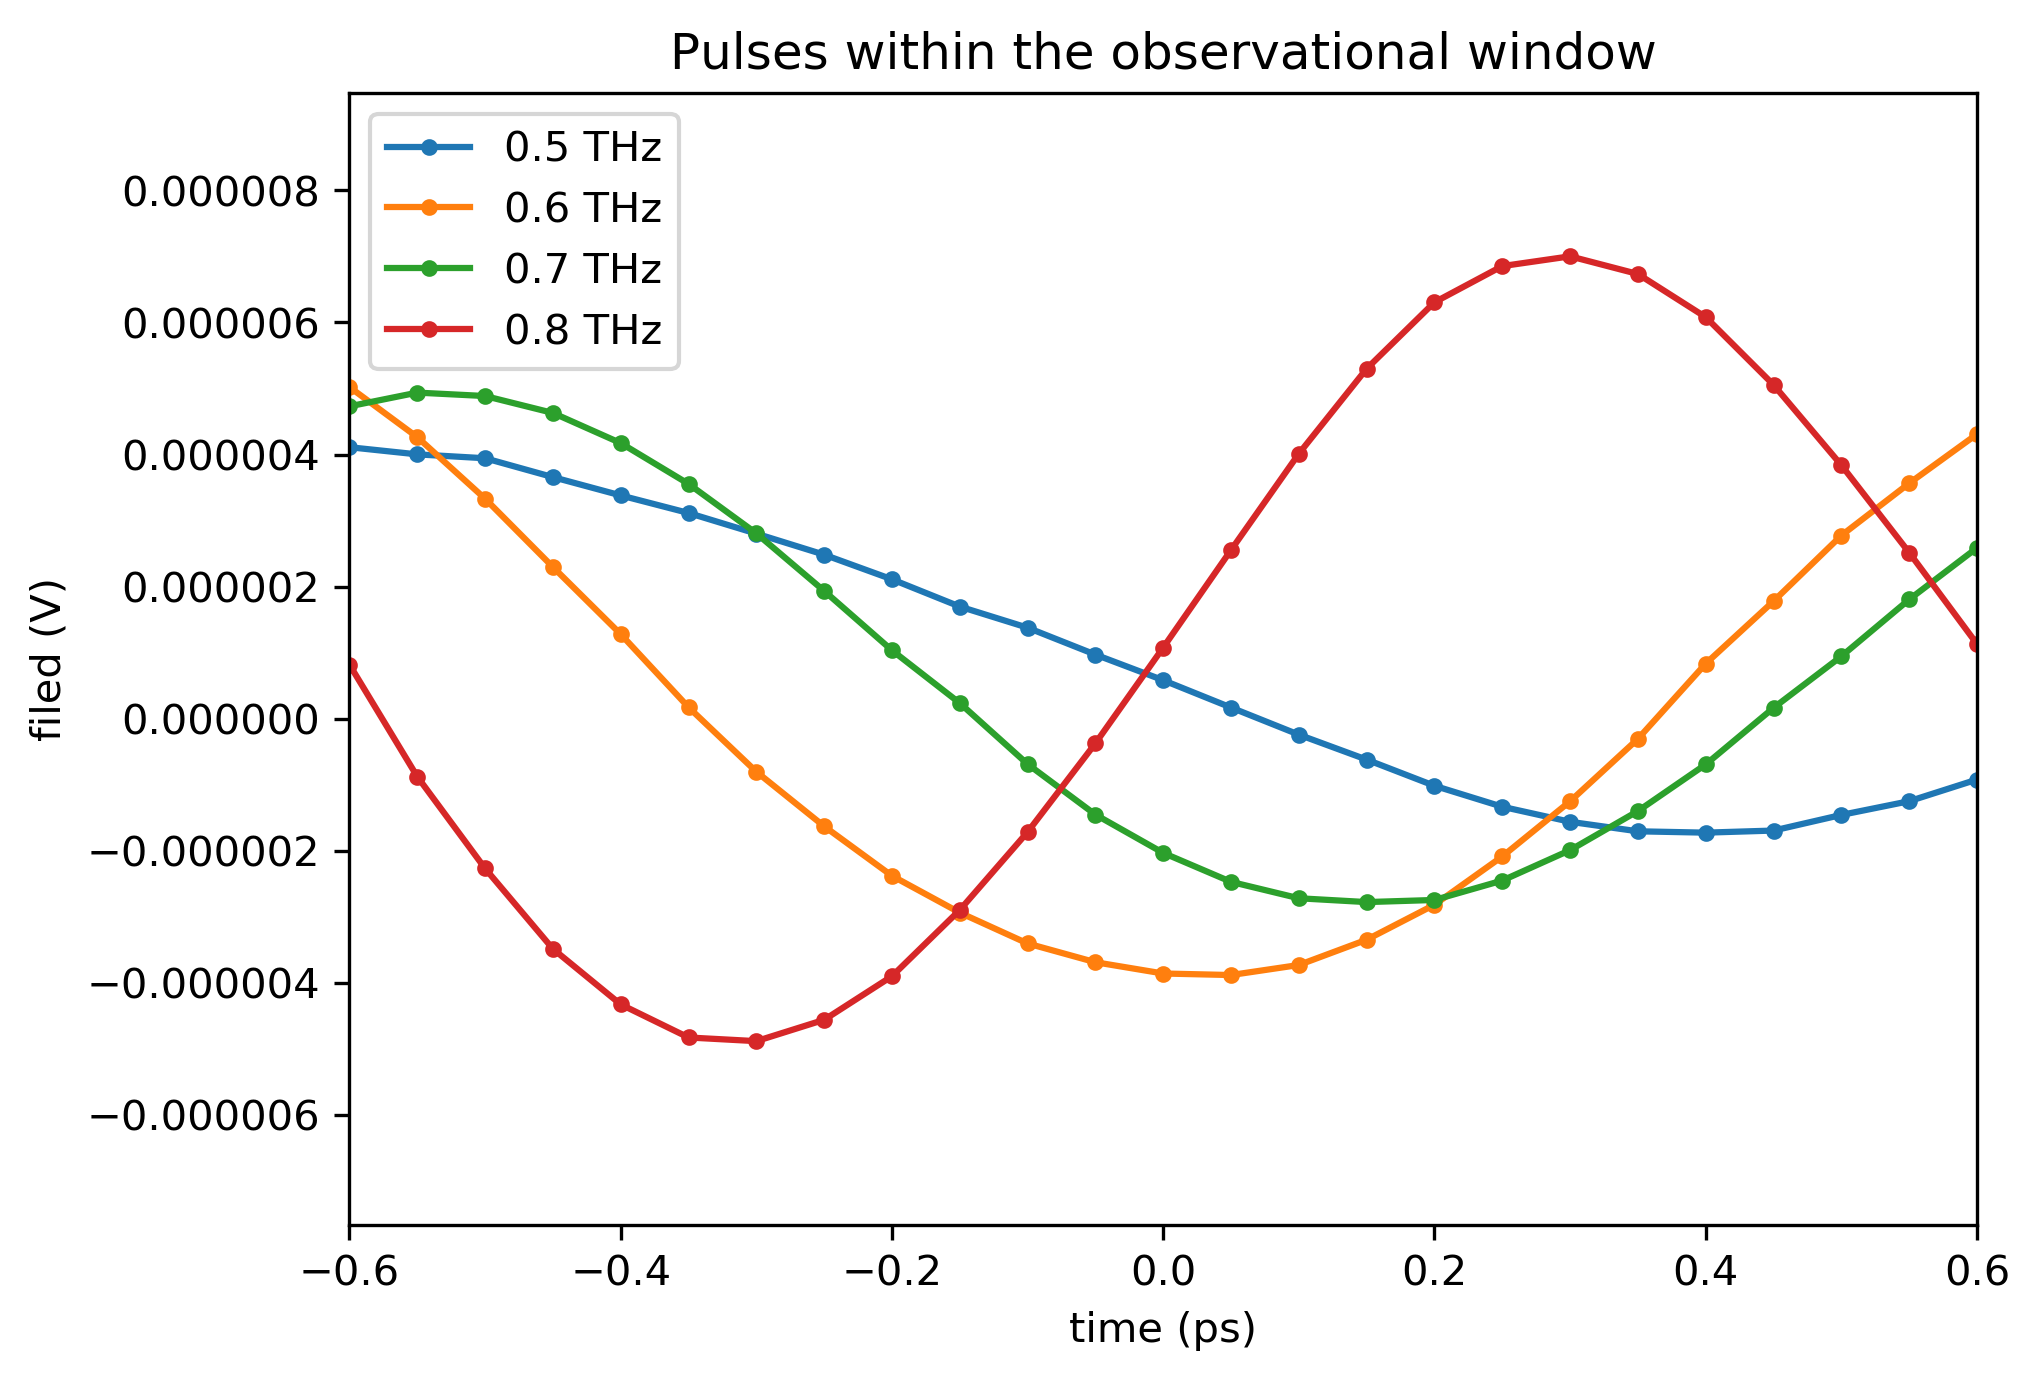

In [8]:
# Plot pulses
plt.figure(figsize=(7, 5), dpi=300)

plt.title("Pulses within the observational window")

for freq, data in pulses.items():
    plt.plot(data.time, data.field, '.-', label=freq)
    
    
plt.xlim(np.array(observational_window))
plt.xlabel('time (ps)')
plt.ylabel('filed (V)')    

plt.legend()
plt.show()  

# Synthesizing superoscillations 

The first step, Calculate the overlap matrix
$$
 S_{ij}(t_1, t_2) = \int_{t_1}^{t_2} E_i(t) E_j(t) dt
$$

In [9]:
def get_overlap(pulse1, pulse2, int_bounds):
    
    # check for common time axis
    assert np.allclose(pulse1.time, pulse2.time)
    time = pulse1.time
    
    indx = np.where((time >= min(int_bounds)) & (time <= max(int_bounds)))
    
    return simps(pulse1.field[indx] * pulse2.field[indx], dx=dtime)

Get $S_{ij}(-\infty, \infty)$

In [10]:
S_infty = [
    [
        get_overlap(pulse1, pulse2, (-np.inf, np.inf)) 
        for pulse2 in pulses.values()
    ] for pulse1 in pulses.values()
]

S_infty = np.array(S_infty)

assert np.allclose(S_infty, S_infty.T)

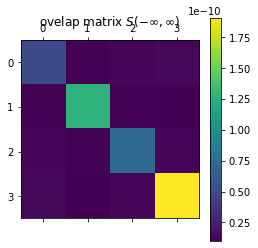

In [11]:
plt.matshow(np.abs(S_infty))
plt.colorbar()
plt.title("ovelap matrix $S(-\infty, \infty)$")
plt.show()

Get overlap matrix for the observational window

In [12]:
S_observ = [
    [
        get_overlap(pulse1, pulse2, observational_window) 
        for pulse2 in pulses.values()
    ] for pulse1 in pulses.values()
]

S_observ = np.array(S_observ)

assert np.allclose(S_observ, S_observ.T)

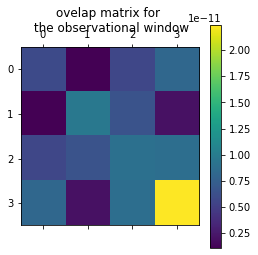

In [13]:
plt.matshow(np.abs(S_observ))
plt.colorbar()
plt.title("ovelap matrix for \n the observational window")
plt.show()

### Finding optimal strategies for generating supperoscilations via eigenvectors

In [14]:
vals, vecs = eigh(S_observ) #, S_infty)

# Ploting superoscilations

# Use refined time axis for the largest frequency component
fastest = pulses[largest_freq]
t = fastest.time
t = np.linspace(t.min(), t.max(), 5 * t.size)

# extract indices of the observational window
ow1 = np.searchsorted(t, observational_window[0], side='left')
ow2 = np.searchsorted(t, observational_window[1], side='right')

# extract indices of the larger window
Lw1 = np.searchsorted(t, 10 * observational_window[0], side='left')
Lw2 = np.searchsorted(t, 10 * observational_window[1], side='right')

for num, eig_vector in enumerate(vecs.T):
    
    # a sanity check
    #assert np.allclose(eig_vector.T @ S_infty @ eig_vector, 1.)
    
    # Normalizing amplitudes
    #eig_vector = eig_vector / np.abs(eig_vector).max()
    
    # get superoscilating field
    field = sum(
        c * _.interp_field(t) for c, _ in zip(eig_vector, pulses.values())
    )
    
    # plot zoom in view
    fig, (ax1, ax1_, ax1__) = plt.subplots(1, 3, figsize=(10, 3), dpi=300)
    
    t_ow = t[ow1:ow2]
    
    color1 = 'tab:red'
    ax1.set_ylabel('combined field (V)', color=color1)
    ax1.plot(t_ow, field[ow1:ow2], color=color1)
    ax1.plot(t_ow, combined_pulse.interp_field(t_ow) / 10, color='black')
    ax1.tick_params(axis='y', labelcolor=color1)
    
    ax1.set_xlabel('time (ps)')
    
    ax2 = ax1.twinx() 
    
    color2 = 'tab:blue'
    ax2.set_ylabel('highest frequecy component (v)', color=color2)
    ax2.plot(t_ow, fastest.interp_field(t_ow), '--', color=color2)
    #ax2.plot(fastest.time, fastest.field, '*')
    #ax2.set_xlim(observational_window)
    ax2.tick_params(axis='y', labelcolor=color2)
    
    
    # plot zoom out view
    
    ax1 = ax1_
    
    t_lw = t[Lw1:Lw2]
    
    ax1.set_ylabel('combined field (V)', color=color1)
    ax1.plot(t_lw, field[Lw1:Lw2], color=color1)
    ax1.tick_params(axis='y', labelcolor=color1)
    
    ax1.plot(t_lw, combined_pulse.interp_field(t_lw), color='black')
    
    ax1.set_xlabel('time (ps)')
    
    ax2 = ax1.twinx() 
    
    ax2.set_ylabel('highest frequecy component (V)', color=color2)
    ax2.plot(t_lw, fastest.interp_field(t_lw), '--', color=color2)
    #ax2.plot(fastest.time, fastest.field, '*')
    #ax2.set_xlim(10 * np.array(observational_window))
    ax2.tick_params(axis='y', labelcolor=color2)
    
    # plot pulses
    ax1 = ax1__
    
    ax1.bar(np.arange(eig_vector.size), eig_vector, color='tab:green')
    ax1.set_xticks(np.arange(eig_vector.size))
    ax1.set_xticklabels(pulses, rotation='vertical')
    #ax1.set_xlabel('THz')
    ax1.set_ylabel('$a_j$')
    
    fig.tight_layout()
    
    plt.savefig('fig_{}.png'.format(num), transparent=True)
    
    plt.show()

# Combinatorial method to match all posible peaks

In [15]:
all_time_delays_indx = list(product(*[_.peaks_indx for _ in pulses.values()]))
len(all_time_delays_indx)


31200

Time window for constructing superoscilations

In [16]:
half_period = pulses[largest_freq].half_period
time_window = np.array([-half_period, half_period])

zero_indx = np.searchsorted(time, 0)

time_window_indx = np.where((time >= -half_period) & (time <= half_period))

## Get superoscilationsby using time delays only 

In [17]:
def get_combined_field(time_delays_indx):
    return sum(
        np.roll(_.field, zero_indx - delay) for delay, _ in zip(time_delays_indx, pulses.values())
    )

def inegral_without_ampl_modulation(time_delays_indx):
    
    return simps(get_combined_field(time_delays_indx)[time_window_indx] ** 2, dx=dtime)

In [47]:
with Pool() as pool:
    intensity_without_ampl_modulation = pool.map(inegral_without_ampl_modulation, tqdm(all_time_delays_indx))

# Extract the best candidates for getting superoscilations by sorting
intensity_without_ampl_modulation = np.array(intensity_without_ampl_modulation)
indx = np.argsort(intensity_without_ampl_modulation)
intensity_without_ampl_modulation = intensity_without_ampl_modulation[indx]

all_time_delays_indx = np.array(all_time_delays_indx)[indx]

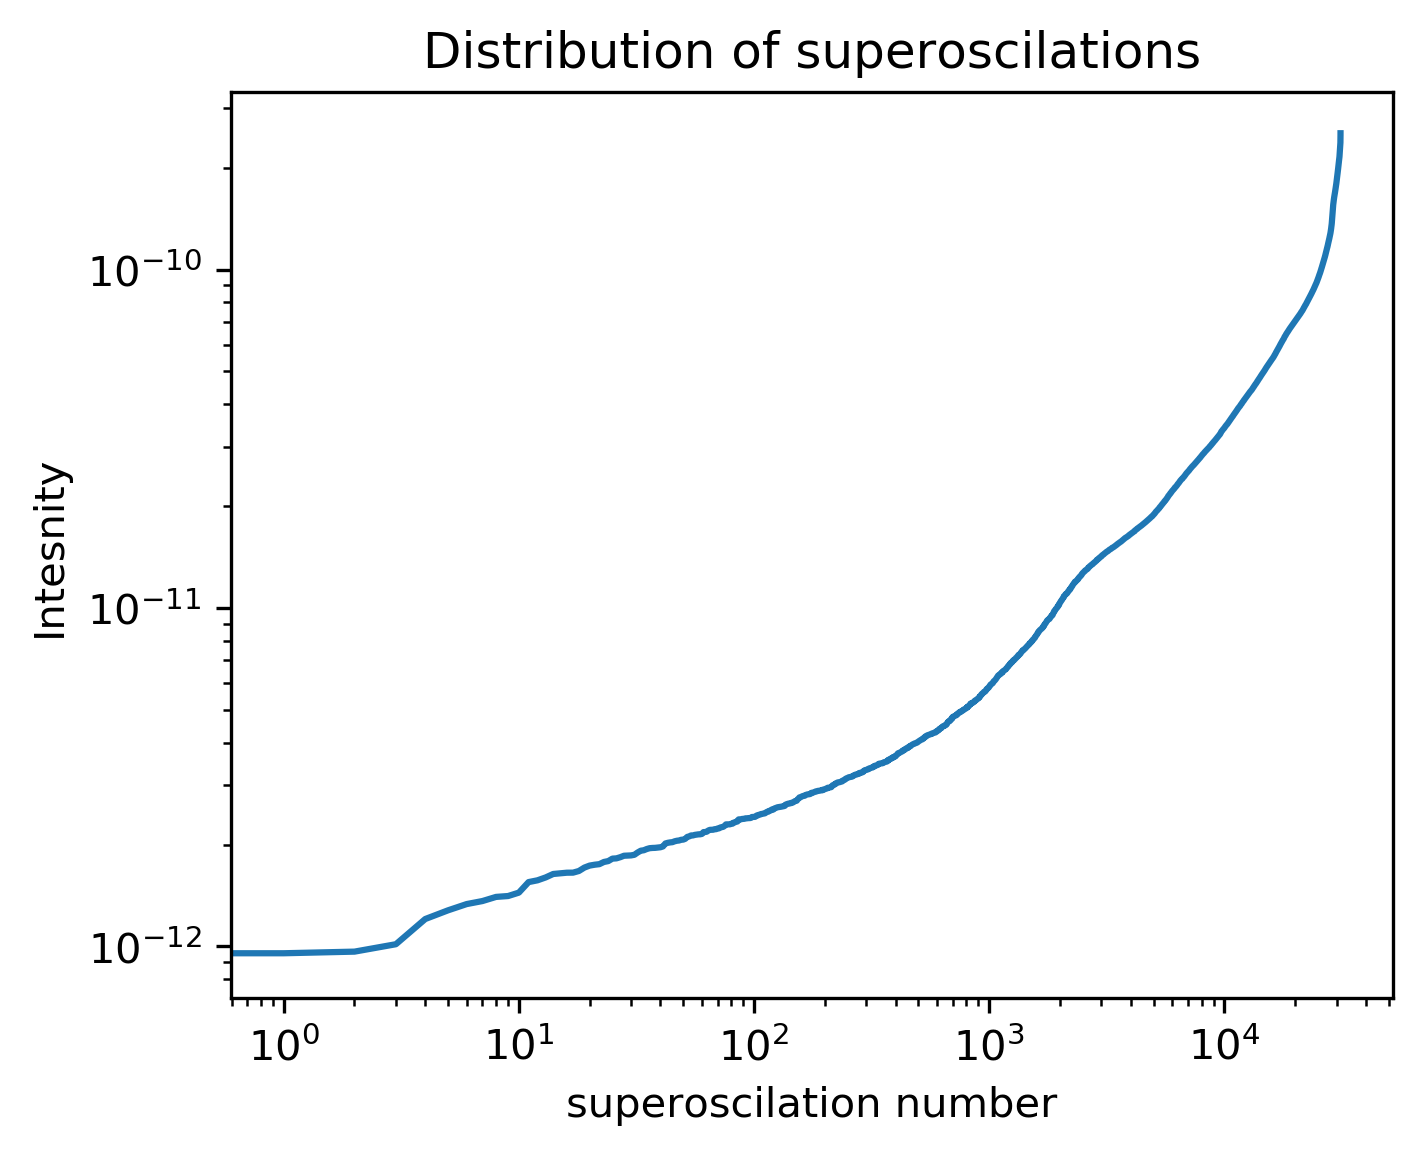

In [44]:
plt.figure(figsize=(5,4), dpi=300)
plt.title("Distribution of superoscilations")
plt.loglog(intensity_without_ampl_modulation)
plt.xlabel('superoscilation number')
plt.ylabel('Intesnity')
plt.show()

Best time delays

In [65]:
time[all_time_delays_indx[:20]]

array([[-1.55, -4.7 , -2.6 , -4.4 ],
       [-3.45, -4.7 , -2.6 , -4.4 ],
       [-1.55, -4.7 ,  0.15, -4.4 ],
       [-3.45, -4.7 ,  0.15, -4.4 ],
       [-1.55, -4.7 ,  1.5 , -4.4 ],
       [-3.45, -4.7 , -1.2 , -4.4 ],
       [-1.55, -4.7 , -1.2 , -4.4 ],
       [-3.45, -4.7 ,  1.5 , -4.4 ],
       [-1.55, -4.7 , -3.95, -4.4 ],
       [-1.55, -4.7 ,  2.9 , -4.4 ],
       [-3.45, -3.15,  4.25, -2.1 ],
       [ 0.4 , -4.7 , -2.6 , -4.4 ],
       [-3.45, -3.15, -3.95, -2.1 ],
       [-1.55, -3.15,  4.25, -2.1 ],
       [-3.45, -4.7 ,  2.9 , -4.4 ],
       [-3.45, -4.7 , -3.95, -4.4 ],
       [-1.55, -4.7 ,  4.25, -4.4 ],
       [ 2.3 ,  0.05,  4.25, -3.2 ],
       [ 0.4 ,  0.05,  4.25, -3.2 ],
       [ 2.3 , -1.55,  4.25, -3.2 ]])

## plot best superoscilations

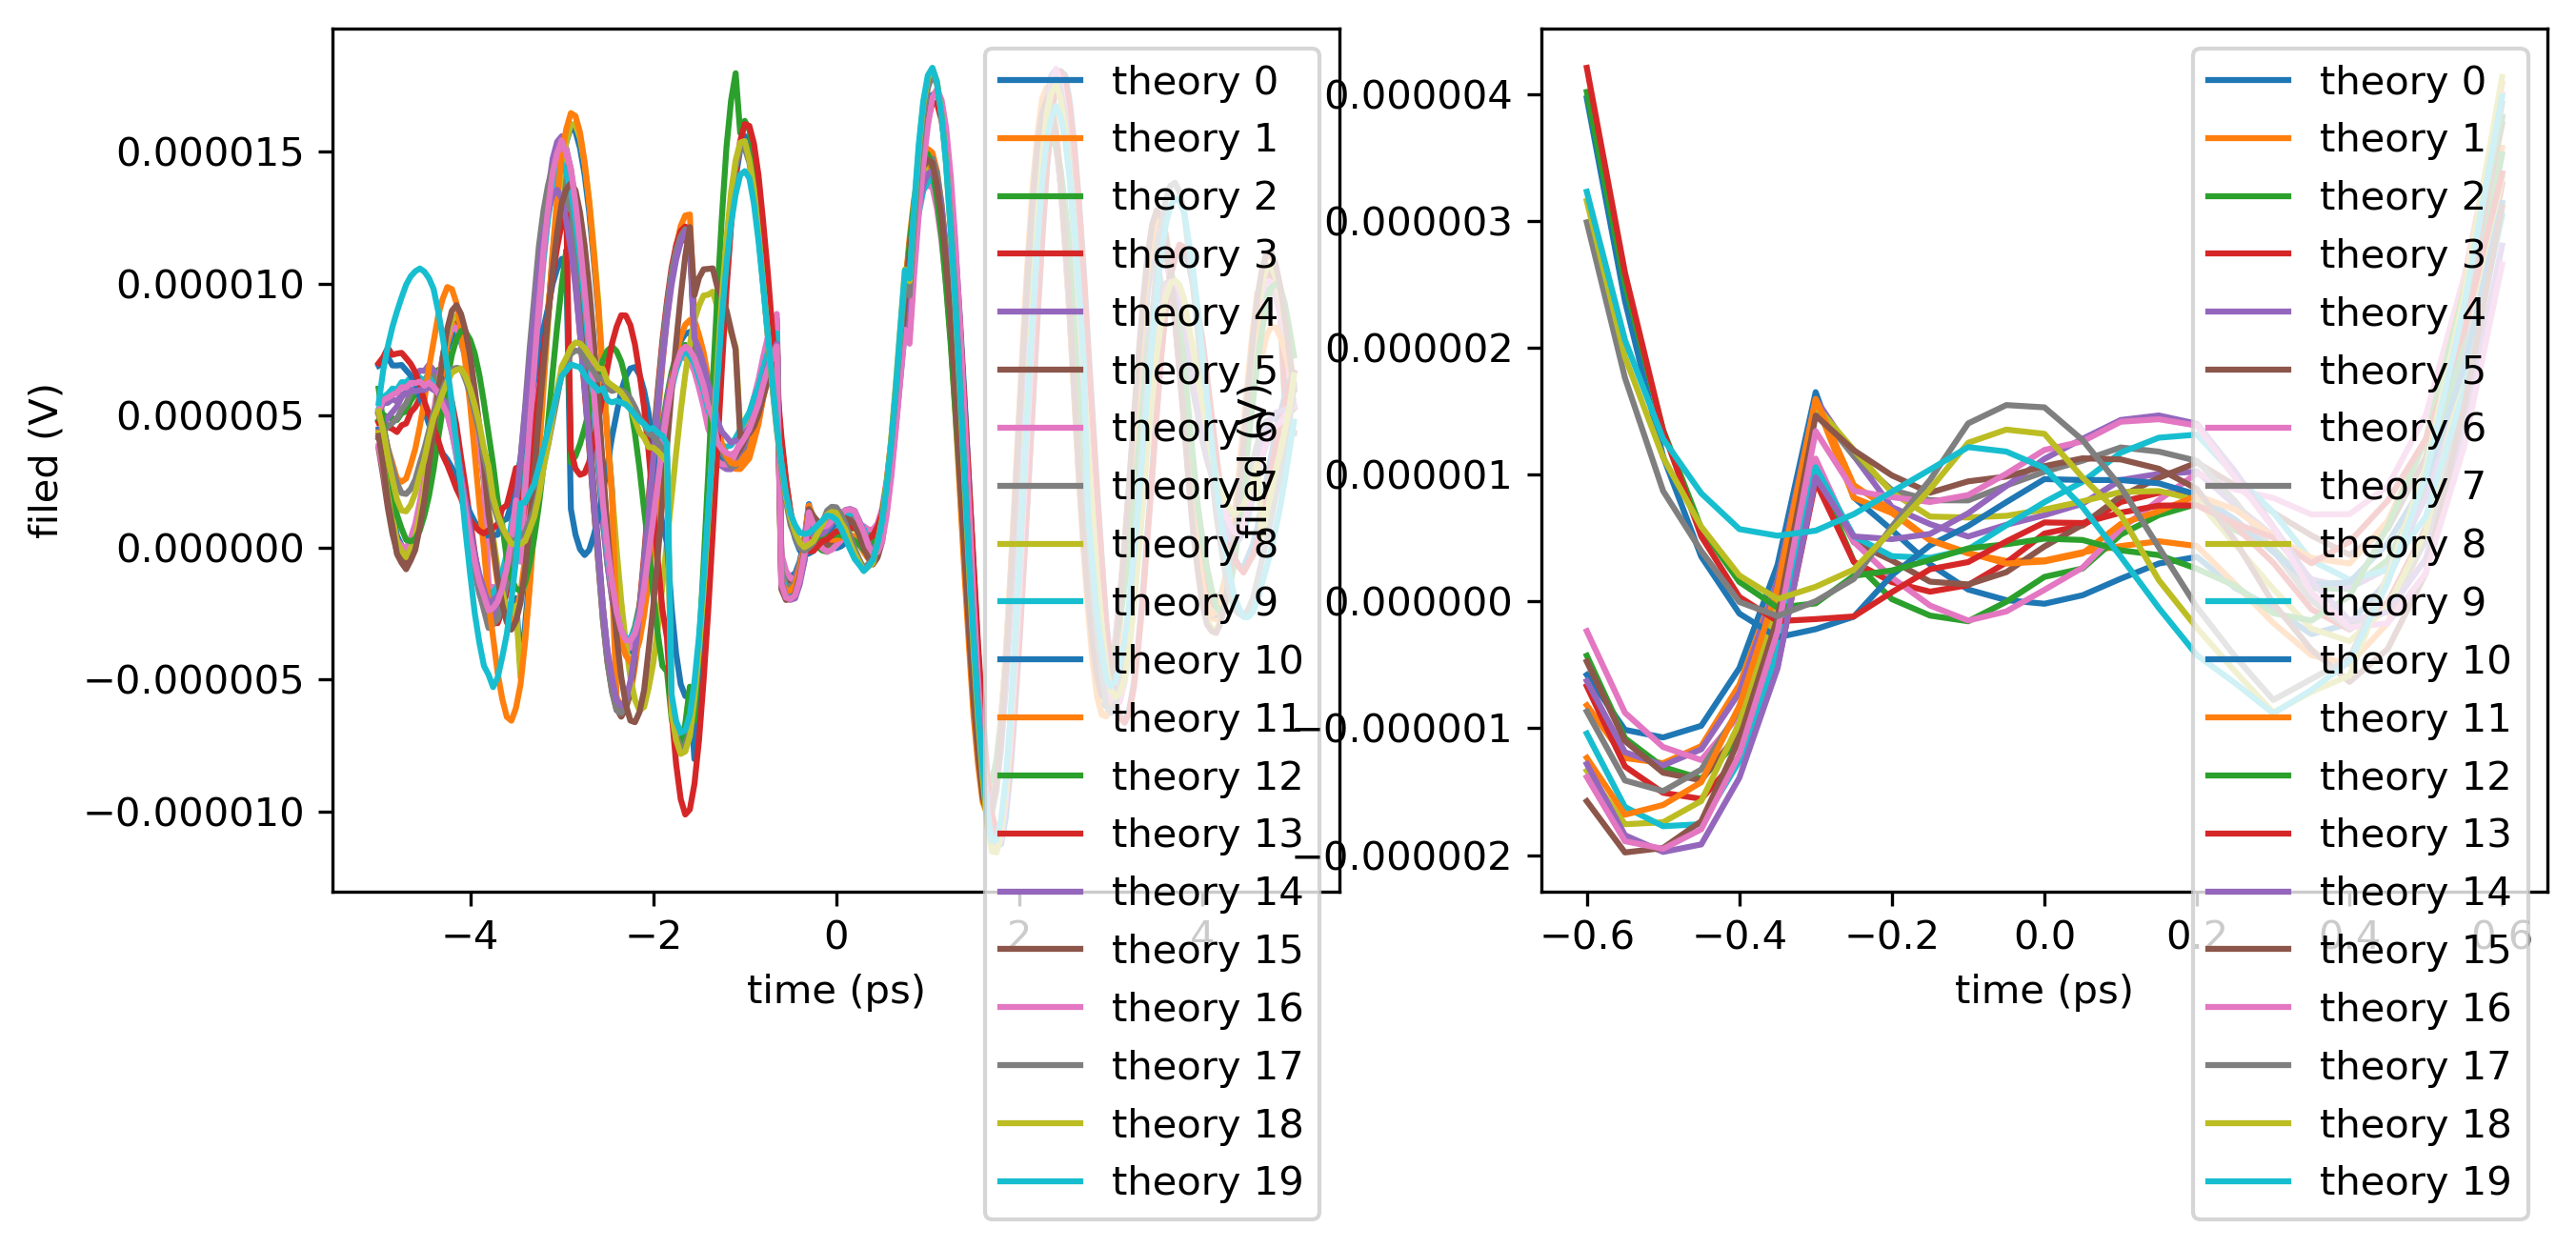

In [72]:
plt.figure(figsize=(10,4), dpi=300)
plt.title("Best superoscilations")

plt.subplot(121)


for n, time_delays_indx in enumerate(all_time_delays_indx[:20]):
    
    plt.plot(time, get_combined_field(time_delays_indx), label="theory {}".format(n))

plt.xlabel('time (ps)')
plt.ylabel('filed (V)')
plt.legend()

plt.subplot(122)

for n, time_delays_indx in enumerate(all_time_delays_indx[:20]):
    
    plt.plot(
        time[time_window_indx], 
        get_combined_field(time_delays_indx)[time_window_indx], 
        label="theory {}".format(n)
    )

plt.xlabel('time (ps)')
plt.ylabel('filed (V)')
plt.legend()

plt.show()

In [73]:
experimental_time_delays = np.array(
       [[ 1.35, -3.15,  0.15,  3.3 ],
       [ 1.35,  4.75,  4.25, -2.65],
       [ 3.25, -3.15,  0.15,  3.3 ],
       [ 3.25, -3.15, -2.6 ,  3.3 ],
       [ 1.35, -3.15, -2.6 ,  3.3 ],
       [ 1.35,  4.75, -3.95, -2.65],
       [ 1.35,  4.75, -2.6 , -2.65],
       [ 1.35, -3.15,  1.5 ,  3.3 ],
       [ 3.25, -3.15,  1.5 ,  3.3 ],
       [ 3.25, -3.15, -3.95,  3.3 ]]
)

[[1.35, -3.15, 0.15, 3.3],
 [1.35, 4.75, 4.25, -2.65],
 [3.25, -3.15, 0.15, 3.3],
 [3.25, -3.15, -2.6, 3.3],
 [1.35, -3.15, -2.6, 3.3],
 [1.35, 4.75, -3.95, -2.65],
 [1.35, 4.75, -2.6, -2.65],
 [1.35, -3.15, 1.5, 3.3],
 [3.25, -3.15, 1.5, 3.3],
 [3.25, -3.15, -3.95, 3.3]]

## Get superoscilationsby using time delays and amplitude modulations 

In [ ]:


def inegral_ampl_modulation(time_delays):
    
    # Amplitude variables
    x = cp.Variable(len(pulses))
    constraints = [0 <= x, x <= 1, sum(x) == 1]

    A = [_.interp_field(time_window - delay) for delay, _ in zip(time_delays, pulses.values())]
    A = np.array(A).T
    
    objective = cp.Minimize(cp.sum_squares(A @ x))
    
    
    prob = cp.Problem(objective, constraints)
    intensity = prob.solve()
    
    return intensity, x.value

In [ ]:
all_time_delays_ampl_modulation = all_time_delays.copy()

with Pool() as pool:
    intensity_ampl_modulation, ampl_values = zip(
        *pool.map(inegral_ampl_modulation, tqdm(all_time_delays_ampl_modulation))
    )

Extract the best candidates for getting superoscilations  

In [ ]:
intensity_ampl_modulation = np.array(intensity_ampl_modulation)

# unlike the time delay permutation objective function, we need to multiply by dt to directly compare two
intensity_ampl_modulation *= time_window[1] - time_window[0]

ampl_values = np.array(ampl_values)
ampl_values = ampl_values[indx]

indx = np.argsort(intensity_ampl_modulation)
intensity_ampl_modulation = intensity_ampl_modulation[indx]

all_time_delays_ampl_modulation = all_time_delays_ampl_modulation[indx]

In [ ]:
plt.figure(figsize=(5,4), dpi=300)
plt.title("Distribution of superoscilations")
plt.loglog(intensity_ampl_modulation, label="phase and amplitude modulation")
plt.loglog(intensity_without_ampl_modulation, label="phase modulation only")
plt.legend()
plt.xlabel('superoscilation number')
plt.ylabel('Intesnity')
plt.show()

## Is there evidence that amplitude modulation is used (hence, helpful)?

In [ ]:
plt.figure(figsize=(5,4), dpi=300)
plt.title("Standard deviation of the amplitude modulations")
plt.loglog(np.std(ampl_values, axis=1))
plt.xlabel('superoscilation number')
plt.ylabel('Standard deviation of the amplitude modulations')
plt.show()

## plot best superoscilations

In [ ]:
def get_combined_field_ampl_modulation(time_delays, amplitudes, time_window):
    return sum(
        a * _.interp_field(time_window - delay) for delay, a, _ in zip(time_delays, amplitudes, pulses.values())
    )

plt.figure(figsize=(10,4), dpi=300)
plt.title("Best superoscilations with amplitude modulation")

plt.subplot(121)

long_time_window = 10 * time_window

for n, (time_delays, amplitudes) in enumerate(zip(all_time_delays_ampl_modulation[:5], ampl_values[:5])):
    plt.plot(
        long_time_window, 
        get_combined_field_ampl_modulation(time_delays, amplitudes, long_time_window), 
        label=str(n)
    )

plt.plot(long_time_window, combined_pulse.interp_field(long_time_window), color='black', label='experimental')

plt.xlabel('time (ps)')
plt.ylabel('filed (V)')
plt.legend()

plt.subplot(122)

for n, (time_delays, amplitudes) in enumerate(zip(all_time_delays_ampl_modulation[:5], ampl_values[:5])):
    plt.plot(
        time_window, 
        get_combined_field_ampl_modulation(time_delays, amplitudes, time_window), 
        label=str(n)
    )
    
plt.plot(time_window, combined_pulse.interp_field(time_window), color='black', label='experimental')

plt.xlabel('time (ps)')
plt.ylabel('filed (V)')
plt.legend()


plt.show()  

In [ ]:
all_time_delays_ampl_modulation[:10]

In [ ]:
ampl_values[:20]